In [1]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
from tqdm import tqdm
from tqdm import trange
from time import sleep
import os
import sys

import numpy as np
import scipy.sparse as sps
import matplotlib.pyplot as plt
import scipy
from scipy.interpolate import RegularGridInterpolator as rgi
from numba import jit,prange

In [2]:
%load_ext line_profiler

# Coding the sim

In [3]:
def genColors(size,n,ntypes=None):
    if ntypes is None:
        ntypes = n
    Colors = np.zeros(size,dtype='int')

    poss = np.random.randint(0,size,(n,2))

    for i,pos in enumerate(poss):
        Colors[pos[0],pos[1]] = i%ntypes +1
    
    for i in range(Colors.shape[0]):
        for j in range(Colors.shape[1]):
            x = poss[:,0]-i
            y = poss[:,1]-j
            Colors[i,j] = np.argmin(x**2+y**2)%ntypes+1
    return Colors

In [4]:
def genState(size,n=1,ntypes = None,center = False,r=0):
    
    if center:
        State = np.zeros(size,dtype='int')
        pos = (size[0]//2,size[1]//2)
        if not r:
            State[pos[0],pos[1]] = -1
        else:
            State[ np.maximum(pos[0]-r,0):np.minimum(pos[0]+r+1,size[0]),
                  np.maximum(pos[1]-r,0):np.minimum(pos[1]+r+1,size[1])] = 1
            findInterface(State)
        C = np.zeros(size)
        C[State>0] = 1
        return C,State
    
    if not ntypes:
        ntypes = n
    
    State = np.zeros(size,dtype='int')
    
    poss = np.random.randint(0,size,(n,len(size)))
    if not r:
        for i,pos in enumerate(poss):
            State[pos[0],pos[1]] = -(i%ntypes +1)
    if r:
        for i,pos in enumerate(poss):
            
            State[ np.maximum(pos[0]-r,0):np.minimum(pos[0]+r+1,size[0]),
                  np.maximum(pos[1]-r,0):np.minimum(pos[1]+r+1,size[1])] = (i%ntypes +1)
            findInterface(State)
    
    C = np.zeros(size)
    C[State>0] = 1
    
    
    return C,State

##  Isotropic growth

In [5]:
@jit(nopython=True,parallel=True,fastmath=True)
def findInterface(State:np.ndarray,poss:np.ndarray=None):

    State2 = np.zeros((State.shape[0]+2,State.shape[1]+2))
    State2[1:-1,1:-1] = State
    State3 = State2.copy()
    
    if poss is not None:
        for idx in prange(len(poss)):
            pos = poss[idx]
            Neigh = State2[pos[0]:pos[0] + 3, pos[1]:pos[1] + 3]
            for xn in range(3):
                for yn in range(3):
                    if Neigh[xn,yn] == 0:
                        Neigh[xn,yn] = -State2[pos[0] + 1, pos[1] + 1]
            State3[pos[0]:pos[0] + 3, pos[1]:pos[1] + 3] = Neigh
        
    else:
        
        for x in prange(State.shape[0]):
            for y in prange(State.shape[1]):
                if State2[x+1,y+1]>0:
                    Neigh = State2[x:x + 3, y:y + 3]
                    for xn in range(3):
                        for yn in range(3):
                            if Neigh[xn,yn] == 0:
                                Neigh[xn,yn] = -State2[x + 1, y + 1]
                    State3[x:x + 3, y:y + 3] = Neigh
    State[:, :] = State3[1:-1, 1:-1]
    # State[:, :] = State2[1:-1, 1:-1]
    return

In [6]:
@jit(nopython=True,parallel=True)
def redistribute(C:np.ndarray,State:np.ndarray,poss:np.ndarray=None):

    C2 = np.zeros((C.shape[0]+2,C.shape[1]+2))
    C2[1:-1,1:-1] = C.copy()

    State2 = np.zeros((State.shape[0]+2,State.shape[1]+2))
    State2[1:-1,1:-1] = State.copy()
    
    if poss is not None:
        for idx in prange(len(poss)):
            pos = poss[idx]
            NeighS = State2[pos[0]:pos[0]+3,pos[1]:pos[1]+3]
            NeighC = C2[pos[0]:pos[0]+3,pos[1]:pos[1]+3]
            
            Residuals = NeighC[1,1] - 1
            counts = np.count_nonzero(NeighS<0)
            if counts:
                for xn in range(3):
                    for yn in range(3):
                        if NeighS[xn,yn]<0:
                            NeighC[xn,yn] = NeighC[xn,yn] + Residuals/counts
            C2[pos[0]:pos[0]+3,pos[1]:pos[1]+3] = NeighC
        
    else :
        for x in prange(State.shape[0]):
            for y in prange(State.shape[1]):
                NeighS = State2[x:x+3,y:y+3]
                NeighC = C2[x:x+3,y:y+3]
                
                Residuals = np.maximum(NeighC[1,1] - 1,0)
                counts = np.count_nonzero(NeighS<0)
                if counts:
                    for z in range(9):
                        if NeighS[z//3,z%3]<0:
                            NeighC[z//3,z%3] = NeighC[z//3,z%3] + Residuals/counts
                
                C2[x:x+3,y:y+3] = NeighC
        
    State[:,:] = State2[1:-1,1:-1]
    C[:,:] = C2[1:-1,1:-1]
    return

In [7]:
@jit(nopython=True,parallel=True)
def normalize(phi:np.ndarray, State:np.ndarray = None):
    
    phi2 = np.zeros((phi.shape[0]+2, phi.shape[1]+2))
    
    phi3 = phi.copy()
    phi2[1:-1,1:-1] = phi
    
    if State is None:
        for i in prange(phi.shape[0]):
            for j in prange(phi.shape[1]):
                Neigh = phi2[i:i+3,j:j+3]
                if Neigh.any():
                    phi3[i,j] = phi2[i+1,j+1]/np.max(Neigh)
        return phi3
    
    else:
        for i in prange(phi.shape[0]):
            for j in prange(phi.shape[1]):
                Neigh = phi2[i:i+3,j:j+3]
                if Neigh.any() and (State[i,j]<0):
                    phi3[i,j] = phi2[i+1,j+1]/np.max(Neigh)
        return phi3

In [8]:
def coef(shape):
    Dx = 1
    Dy = 1
    aS = Dy*np.ones(shape)
    aW = Dx*np.ones(shape)
    aE = Dx*np.ones(shape)
    aN = Dy*np.ones(shape)
    aP = -(aE+aW+aS+aN)
    return aS,aW,aP,aE,aN

def Neumann(aS,aW,aP,aE,aN):
    #West
    aP[:,0] = aP[:,0] + aW[:,0]
    aW[:,0] = 0
    #East
    aP[:,-1] = aP[:,-1] + aE[:,-1]
    aE[:,-1] = 0
    #South
    aP[0,:] = aP[0,:] + aS[0,:]
    aS[0,:] = 0
    #North
    aP[-1,:] = aP[-1,:] + aN[-1,:]
    aN[-1,:] = 0
    return aS,aW,aP,aE,aN

def Assemble(aS, aW, aP, aE, aN):
    shape = aS.shape
    size = np.prod(shape)

    diagP = aP.reshape((size))
    diagS = aS[1:,:].reshape(size-shape[1])
    diagW = aW.reshape(size)[1:]
    diagE = aE.reshape(size)[:-1]
    diagN = aN[:-1,:].reshape(size-shape[1])

    A = sps.diags([diagP,diagS,diagW,diagE,diagN],
                  [0,-shape[1],-1,1,shape[1]],shape=(size,size),format='csc')
    return A

def Diffmat(arr,Dr=0.24,n=3):
    shape = arr.shape
    coeffs = Neumann(*coef(shape))
    D = Assemble(*coeffs)
    return (sps.eye(np.prod(shape)) + Dr*D ) **n

def doDiff(State:np.ndarray,diffmat:sps.csc_matrix):
    
    State2:np.ndarray = State.flatten()
    State2[State2<0] = 0
    
    phi = diffmat*State2
    
    phi = phi.reshape(State.shape)
    
    return phi

___Optimal parameters___

- $K = 3$

- $\gamma = 1.79$

- $D_r = 0.24$

In [9]:
n = 3
idealGamma = 1.79
Dr= 0.24
gamma = 1.764

In [10]:
def solveBeta(gamma=idealGamma,n=n):
    state = np.zeros((3,3*n))
    state[:,:n+1] = 1
    state[:,n+1] = -1
    phi = doDiff(state,Diffmat(state,Dr=Dr,n=3))
    phiNorm = normalize(phi,state)
    return (phiNorm[1,n+1])**(-gamma)

In [11]:
beta = solveBeta()
print(beta)

3.2823941738315927


In [13]:
def solveVred(phi,State,beta=beta,gamma=idealGamma):
    phiNorm = normalize(phi,State)
    
    vred = np.zeros(phiNorm.shape)
    where = State<0
    vred[where] = beta*(phiNorm[where]**gamma)
    
    return vred

In [14]:
def CAStep(C,State,G,phi,vred,redist=False, upperlim = None):
    
    upperlimflag = False
    updateflag = 0
    
    redistLimit = 0.01
    
    gr = G*vred
    
    C[State<0] = C[State<0] + gr[State<0]
    
    if (gr>=redistLimit).any():
        redist = True

    if upperlim is not None:
        if (gr[State<0]>upperlim).any():
            upperlimflag = True
            return C,State,updateflag,upperlimflag
    
    # Checking if any cell is full
    
    Cgreater = C>=1
    Cgreater[State>0] = 0
    
    where = None
    
    while Cgreater.any():
        
        where = np.array(np.where((C>=1) & (State<0))).T
        # Set the state to new
        
        State[Cgreater] = -State[Cgreater]
        
        # Updating the states

        findInterface(State,poss=where)
        
        if redist:
            # Redistributing
            whereRedist = np.array(np.where(C>1)).T
            redistribute(C,State)
            
        C[State>0] = 1
        
        # Updating the phi, vred and G
        
        updateflag = 1
        
        # Setting the boundary conditions back
        Cgreater = C>=1
        Cgreater[State>0] = 0
        
    return C,State,updateflag,upperlimflag

In [15]:
def runCA(size,G,gamma,ngrains = None,n=None,r=1,nevery=1,upperlim = None):

    beta = solveBeta(gamma = gamma)
    if ngrains:
        C,State = genState(size,n=ngrains)
    else:
        C,State = genState(size,center=True)

    # Initial phi and vred for the first step
    phi = np.ones(State.shape)
    vred = np.ones(State.shape)
    
    # Generate the diffusion matrix
    diffmat = Diffmat(State,Dr=0.24,n=3)
    
    if n:
        Clist = np.zeros((n,*size))
        Statelist = np.zeros((n,*size))
        
        for i in range(n):
            C,State,update,upperlimflag = CAStep(C,State,G,phi,vred,upperlim = upperlim)
            if upperlimflag:
                return Clist,Statelist,upperlimflag
            if update:
                phi = doDiff(State,diffmat)
                vred = solveVred(phi,State,beta,gamma)
            Clist[i] = C
            Statelist[i] = State
    else:
        Clist = [C.copy()]
        Statelist = [State.copy()]
        i=0
        while (C<1).any():
            C,State,update,upperlimflag = CAStep(C,State,G,phi,vred,upperlim = upperlim)
            if upperlimflag:
                return Clist,Statelist,upperlimflag
            if update:
                phi = doDiff(State,diffmat)
                vred = solveVred(phi,State,beta,gamma)
            if i%nevery == 0:
                Clist.append(C.copy())
                Statelist.append(State.copy())
            i+=1
    return Clist,Statelist,upperlimflag

In [16]:
def mu(phi,mu0,eps0,m,thetas,State):
    
    angles = np.zeros(phi.shape)
    mu = np.zeros(phi.shape)
    
    where = State<0
    # Find angle between gradient and x axis
    angles[where] = np.arctan2(*np.gradient(phi,))[where]
    
    # Find mu
    mu[where] = mu0*(1+eps0*np.cos(m*(angles[where]-thetas[where])) )
    
    return mu

In [17]:
def AnalRN(TN,Tliq=1733):
    delT = np.clip(Tliq - TN,a_min=0,a_max=None)
    
    Dl = 1.8E-9 
    ml = -2
    k = 0.9
    Gamma = 3E-7
    C0 = 17 
    
    RN = Dl/(5.51*np.pi**2 *(-ml*(1-k))**1.5 * Gamma)* delT**2.5/C0**1.5
    
    # m/s to cm/s
    return RN*100

nmax = 1E9 # 1/m3

def AnalNdDelT(Temp,nmax,DelTmean,DelTSig,Tliq = 1733):
    
    # DelT = Tliq -np.mean(Temp[Temp<Tliq])
    DelT = np.clip(Tliq - Temp,a_min=0,a_max=None)
    return nmax/(DelTSig*np.sqrt(2*np.pi))*np.exp(-(DelT-DelTmean)**2/(2*DelTSig**2))

In [18]:
def runGrowthSim(dx,State,time,G,upperlim = 0.1,every=True,meltplace = None):
    
    time_sim = [time[0]]
    
    C = np.zeros(State.shape)
    C[State>0] = 1
    
    phi = np.ones(State.shape)
    vred = np.ones(State.shape)
    diffmat = Diffmat(State,Dr=0.24,n=3)
    
    Statelist = [State.copy()]
    Clist = [C.copy()] 
    
    for i in trange(len(time)-1):
        
        if meltplace is not None:
            State[meltplace[i] != 0] = 0
            C[meltplace[i] != 0] = 0
            findInterface(State)
        
        while time_sim[-1]<time[i+1]:
            
            dtsim = time[i+1]-time_sim[-1]
            
            # Linear interpolation of G
            Gstep =  G[i]*(1- (time_sim[-1] - time[i])/(time[i+1]-time[i]) ) + G[i+1]*(1- (time[i+1] - time_sim[-1])/(time[i+1]-time[i]))
            
            # Trial step
            Cnew,Statenew,updateflag,upperlimflag = CAStep(C.copy(), 
                                                    State.copy(), 
                                                    Gstep*dtsim/dx,
                                                    phi,
                                                    vred, 
                                                    upperlim=upperlim
                                                    )

            if upperlimflag:
                # Define a dt to satisfy the limit / 2
                dtsim = (upperlim * dx) / (2*np.max( (Gstep * vred)[State<0] ) )
                
                # Step
                Cnew,Statenew,updateflag,upperlimflag = CAStep(C.copy(),
                                                        State.copy(),
                                                        Gstep*dtsim/dx,
                                                        phi,
                                                        vred,
                                                        upperlim=upperlim
                                                        )

            # Update
            C = Cnew
            State = Statenew
            
            if updateflag:
                phi = doDiff(State,diffmat)
                vred = solveVred(phi,State,beta,gamma)
                
            if every:
                Clist.append(C.copy())
                Statelist.append(State.copy())
            
            time_sim.append(time_sim[-1]+dtsim)

        if not every:
            Clist.append(C.copy())
            Statelist.append(State.copy())
    return time_sim,Statelist,Clist

## Test cases for illustration

### Show without phi

In [94]:
size = (100,100)
G = 0.3

Clist,Statelist,upperlimflag = runCA(size=size, G=G, gamma=0,nevery=1)
Clistcirc,Statelistcirc,upperlimflag= runCA(size=size, G=G, gamma=1.79,nevery=1)

In [97]:
@interact(x = (0,len(Clist)-1),y = (0,len(Clistcirc)-1))
def plot(x,y):
    fig,axs = plt.subplots(2)
    fig.set_figwidth(18)
    fig.set_figheight(10)
    a=axs[0].imshow(Clist[x],origin='lower',vmin=0)
    fig.colorbar(a)
    b=axs[1].imshow(Clistcirc[y],origin='lower',vmin=0,vmax=1)
    fig.colorbar(b)

interactive(children=(IntSlider(value=6, description='x', max=12), IntSlider(value=4, description='y', max=9),…

### Do parametric study for circularity

In [26]:
def circularity(Clist,after = 1):
    
    center = np.array(Clist.shape[1:],dtype='int')/2
    
    step = int(len(Clist)*after-1)
    C = Clist[step]
    indices = np.indices(C.shape)
    
    dist = indices - center[:,np.newaxis,np.newaxis]
    distances = np.sqrt( np.sum( dist**2 ,axis = 0))
    
    cond = (C>0) & (C<1)
    R = distances[cond] + C[cond]-0.5
    if len(R) and np.mean(R):
        return (np.max(R)-np.min(R))/np.mean(R)
    else :
        return 0

In [39]:
def doCircAnal(gamma):
    Clist,_,_ = runCA(n=5000,size = (201,201), G = 0.01,gamma= gamma)
    return circularity(Clist)

In [40]:
n = 20
gammas = np.linspace(0,3,n)
cerrs = np.zeros(n)
for i in tqdm(range(n)):
    cerrs[i] = doCircAnal(gammas[i])

100%|██████████| 20/20 [03:50<00:00, 11.55s/it]


In [41]:
ranges = [(gammas[np.argmin(cerrs)-1] + gammas[np.argmin(cerrs)])/2, (gammas[np.argmin(cerrs)+1] + gammas[np.argmin(cerrs)])/2]

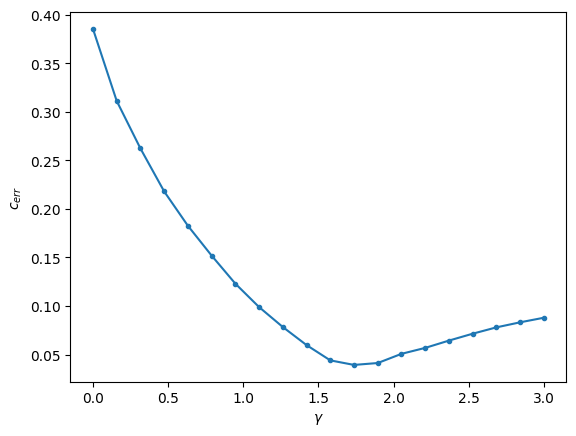

In [42]:
plt.plot(gammas,cerrs,'.-')
plt.ylabel('$c_{err}$')
plt.xlabel('$\gamma$')

In [43]:
n=10
gammas = np.linspace(ranges[0],ranges[1],n)
cerrs = np.zeros(n)
for i in tqdm(range(n)):
    cerrs[i] = doCircAnal(gammas[i])

100%|██████████| 10/10 [01:56<00:00, 11.60s/it]


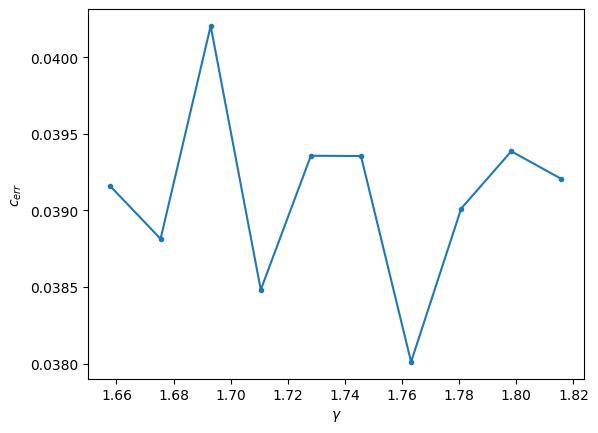

In [44]:
plt.plot(gammas,cerrs,'.-')
plt.ylabel('$c_{err}$')
plt.xlabel('$\gamma$')

In [45]:
ranges = [(gammas[np.argmin(cerrs)-1] + gammas[np.argmin(cerrs)])/2, (gammas[np.argmin(cerrs)+1] + gammas[np.argmin(cerrs)])/2]
ranges

[1.7543859649122806, 1.7719298245614035]

In [46]:
n=10
gammas = np.linspace(ranges[0],ranges[1],n)
cerrs = np.zeros(n)
for i in tqdm(range(n)):
    cerrs[i] = doCircAnal(gammas[i])

100%|██████████| 10/10 [01:53<00:00, 11.36s/it]


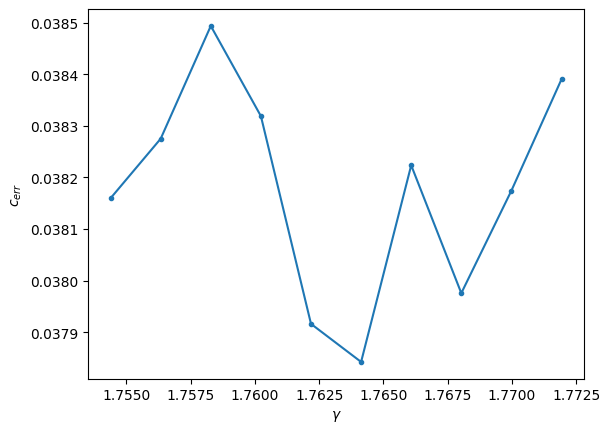

In [47]:
plt.plot(gammas,cerrs,'.-')
plt.ylabel('$c_{err}$')
plt.xlabel('$\gamma$')

In [48]:
gamma = gammas[np.argmin(cerrs)]
print(gamma)

1.7641325536062378


In [49]:
np.min(cerrs)

0.03784237301775173

### $\gamma$ value

In [19]:
gamma = 1.7641325536062378

### Dendritic growth

In [121]:
m = 5
eps = 0.2
nevery = 10

ngrains = 20
C,State = genState((300,300),n=ngrains,r=3)
# C,State = genState((200,200),center=True)

# deltaT = np.linspace(1,2,State.shape[0])/1E2
deltaT = 1E-2

graintheta = np.random.uniform(0,2*np.pi,ngrains)
graintheta[0] = 0
# graintheta = np.ones(ngrains)*np.pi/180*22.5
print(graintheta/np.pi*180)
thetas = np.zeros(State.shape)
thetas[State<0] = graintheta[-State[State<0]-1]

beta = solveBeta(gamma = gamma)

# Initial phi and vred for the first step
phi = np.ones(State.shape)
vred = np.ones(State.shape)

G = mu(phi,mu0=1,eps0=0,m=0,thetas=thetas,State=State)*deltaT

# Generate the diffusion matrix
diffmat = Diffmat(State,Dr=0.24,n=3)


Clist = [C.copy()]
Statelist = [State.copy()]
Glist = [phi.copy()]
i=0

while (C<1).any():
    C,State,update,upperlimflag = CAStep(C,State,G,phi,vred,redist=True)
    if update:
        phi = doDiff(State,diffmat)
        vred = solveVred(phi,State,beta,gamma)
        
        thetas[:,:] = 0
        thetas[State<0] = graintheta[-State[State<0]-1]
        G = mu(phi,mu0=1,eps0=eps,m=m,thetas=thetas,State=State)*deltaT
    
    if i%nevery == 0:
        Clist.append(C.copy())
        Statelist.append(State.copy())
        Glist.append(phi.copy())
    i+=1
Clist.append(C.copy())
Statelist.append(State.copy())
Glist.append(phi.copy())

[  0.         271.13204396 112.68648117  46.40181553 320.81275303
 334.30674442 137.65287966 340.49584548 187.31389595 241.71835013
  82.56139549 301.04972165 251.16092403 294.87717112  72.52051395
 200.70227972 236.64411699 146.87162591  21.62004827 134.66959007]


In [122]:
@interact(x = (0,len(Clist)-1))
def plot(x):
    # Set colorbars to 0-1
    fig,axs = plt.subplots(2)
    fig.set_figwidth(18)
    fig.set_figheight(15)
    a=axs[0].imshow(Clist[x],origin='lower',vmin=0,vmax=1)
    fig.colorbar(a)
    b=axs[1].imshow(Statelist[x],origin='lower')
    fig.colorbar(b)
    # c=axs[2].imshow(Glist[x],origin='lower')
    # fig.colorbar(c)

interactive(children=(IntSlider(value=483, description='x', max=967), Output()), _dom_classes=('widget-interac…

# Validation

## Polymer Recrystallization 

In [20]:
def GrowthT(T):
    N0 = 17.4E6
    v0 = 2.1E4
    UbyR = 755
    Kg = 534858
    T0m = 467
    phi = 0.155
    Tg = 266
    rho = 900
    cp = 2.14E3
    kp = 0.193
    return v0*np.exp(-(UbyR)/(T-Tg+30))*np.exp(-Kg/(T*(T0m-T)))

def Nucleation(T):
    N0 = 17.4E6
    phi = 0.155
    v0 = 2.1E4
    UbyR = 755
    Kg = 534858
    T0m = 467
    Tg = 266
    rho = 900
    cp = 2.14E3
    kp = 0.193
    return 1.458*(N0*np.exp(phi*(T0m-T)))**(2/3)

In [21]:
def numAlpha(imagelist):
    alphas = np.zeros(len(imagelist))
    alphas = np.sum(Clist,axis=tuple(range(1,len(Clist.shape))))/np.product(Clist.shape[1:])
    return alphas

def analAlpha(T):
    t = np.linspace(0,6,600)
    alphas = 1-np.exp(-np.pi*Nucleation(T)*(GrowthT(T)**2)*(t**2))
    return t,alphas

In [22]:
def runCAAlpha(size,G,gamma,ngrains = None):
    alphs = [0]
    
    beta = solveBeta(gamma = gamma)
    if ngrains:
        C,State = genState(size,n=ngrains)
    else:
        C,State = genState(size,center=True)

    # Initial phi and vred for the first step
    phi = np.ones(State.shape)
    vred = np.ones(State.shape)
    
    # Generate the diffusion matrix
    diffmat = Diffmat(State,Dr=0.24,n=3)
    
    i=0
    Statelist = []
    while (C<1).any():
        C,State,update,upperlimflag = CAStep(C,State,G,phi,vred,redist = True)
        Statelist.append(State.copy())
        if update:
            phi = doDiff(State,diffmat)
            vred = solveVred(phi,State,beta,gamma)

        alphs.append(np.sum(C)/np.product(C.shape))
        i+=1
    
    return alphs,Statelist

In [23]:
L = 2E-4
area = L**2

# Ts = np.array([340,345,350,355,360])
Ts = np.array([340])

In [24]:
domainsize = (600,600)
dx = L/domainsize[0]
dt = 4/1E5
numAlphas = []
analAlphas = []

for i,T in enumerate(tqdm(Ts)):
    nseeds = int(Nucleation(T)*area)
    Growthrate = GrowthT(T)*dt/dx
    
    numalph,Statelist = runCAAlpha(domainsize, G=Growthrate, gamma=gamma, ngrains=nseeds)
    tnum = np.arange(len(numalph))*dt

    numAlphas.append((tnum,numalph))
    tanal,analaplh = analAlpha(T)
    analAlphas.append((tanal,analaplh))

100%|██████████| 1/1 [06:09<00:00, 369.08s/it]


(0.0, 0.4)

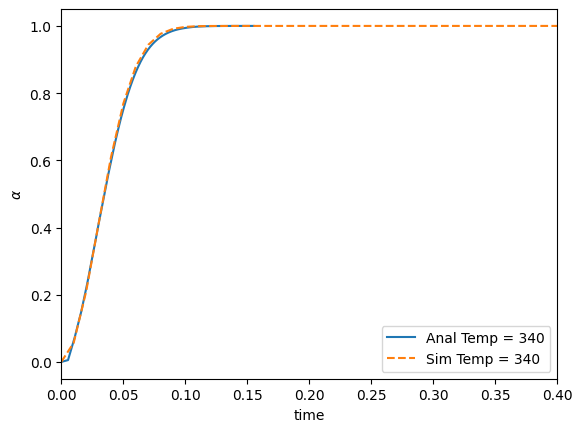

In [26]:
for i in range(len(numAlphas)):
    plt.plot(numAlphas[i][0], numAlphas[i][1],
             label='Anal Temp = {}'.format(Ts[i]))
    plt.plot(analAlphas[i][0], analAlphas[i][1],'--',
             label='Sim Temp = {}'.format(Ts[i]))
plt.legend()
plt.xlabel('time')
plt.ylabel('$\\alpha$')
plt.xlim(0,0.4)
# plt.savefig('Polymer Recryst.png',bbox_inches='tight')

## Do a test with different grain orientations

In [176]:
m = 4
eps = 0.2
nevery = 10

ngrains = 20
C,State = genState((200,200),n=ngrains)
State[:,:] = 0

for i in range(ngrains):
    y = np.random.randint(0,200,1)
    State[y,5] = -i-1
# C,State = genState((200,200),center=True)

# deltaT = np.linspace(1,2,State.shape[0])/1E2
deltaT = 5E-3

graintheta = np.random.uniform(0,2*np.pi,ngrains)
# graintheta = np.ones(ngrains)*np.pi/180*22.5
print(graintheta/np.pi*180)
thetas = np.zeros(State.shape)
thetas[State<0] = graintheta[-State[State<0]-1]

beta = solveBeta(gamma = gamma)

# Initial phi and vred for the first step
phi = np.ones(State.shape)
vred = np.ones(State.shape)

G = mu(phi,mu0=1,eps0=0,m=0,thetas=thetas,State=State)*deltaT

# Generate the diffusion matrix
diffmat = Diffmat(State,Dr=0.24,n=3)


Clist = [C.copy()]
Statelist = [State.copy()]
Glist = [phi.copy()]
i=0
bar = tqdm(total=100)
while (C<1).any():
    C,State,update = CAStep(C,State,G,phi,vred)
    if update:
        phi = doDiff(State,diffmat)
        vred = solveVred(phi,State,beta,gamma)
        
        thetas[:,:] = 0
        thetas[State<0] = graintheta[-State[State<0]-1]
        G = mu(phi,mu0=1,eps0=eps,m=m,thetas=thetas,State=State)*deltaT
    
    if i%nevery == 0:
        Clist.append(C.copy())
        Statelist.append(State.copy())
        Glist.append(phi.copy())
    value = np.sum(C)/np.product(C.shape)
    bar.update(value*100)
    i+=1
bar.close()
Clist.append(C.copy())
Statelist.append(State.copy())
Glist.append(phi.copy())

[324.71638621 122.39096655 294.98063448  24.42554696 173.48734082
  69.51871198 190.3307617  182.86328547 166.52081852 300.0441771
  65.69661952  65.38502314 350.64845507 200.15930988  67.18489072
 124.78103202 316.25289598 266.56385469  63.54640875 227.25544199]


2364086.312719619it [02:41, 14609.93it/s]                        


In [177]:
np.cos( 4 * graintheta)

array([-0.77862064, -0.63693794, -0.17231659, -0.13402403,  0.89840627,
        0.14046661,  0.75099859,  0.98008743,  0.58896046, -0.50266856,
       -0.12556737, -0.14711731,  0.79434911,  0.1626847 , -0.021997  ,
       -0.75612912, -0.99617706,  0.97136454, -0.27252148, -0.98762884])

In [178]:
[np.count_nonzero(Statelist[-1][:,-1]==_) for _ in range(1,ngrains+1)]

[0, 0, 0, 0, 69, 0, 84, 0, 0, 0, 0, 0, 31, 0, 16, 0, 0, 0, 0, 0]

In [179]:
@interact(x = (0,len(Clist)-1))
def plot(x):
    # Set colorbars to 0-1
    fig,axs = plt.subplots(2)
    fig.set_figwidth(18)
    fig.set_figheight(15)
    a=axs[0].imshow(Clist[x],origin='lower',vmin=0,vmax=1)
    fig.colorbar(a)
    b=axs[1].imshow(Statelist[x],origin='lower')
    fig.colorbar(b)
    # c=axs[2].imshow(Glist[x],origin='lower')
    # fig.colorbar(c)

interactive(children=(IntSlider(value=2141, description='x', max=4282), Output()), _dom_classes=('widget-inter…

## Do a casting with a gaussian growth field

In [133]:
# Initialize the field

size = (200,300)

State= np.zeros(size)
C = np.zeros(size)

# Initialize random grains on the edges

n = 10                  # Number of grains on each side
xs = np.random.randint(0,size[1],(2*n))
ys = np.random.randint(0,size[0],(2*n))

for i in range(4*n):
    if i//n == 0:
        State[ys[i],0] = i+1
    if i//n == 1:
        State[ys[i],-1] = i+1
    if i//n == 2:
        State[0,xs[i-2*n]] = i+1
    if i//n == 3:
        State[-1,xs[i-2*n]] = i+1

findInterface(State)
C[State>0] = 1

In [134]:
mesh = np.meshgrid(np.arange(size[0]),np.arange(size[1]),indexing='ij')

Gauss = np.exp(-((mesh[0]-size[0]/2)**2/(size[0]**2)+(mesh[1]-size[1]/2)**2/(size[1]**2))*10)
Gauss.min()

# Generate growth rate

G0 = 1E-3
Scale = 3E-3
G = G0 + (1-Gauss)*Scale

In [23]:
beta = solveBeta(gamma = gamma)

# Initial phi and vred for the first step
phi = np.ones(State.shape)
vred = np.ones(State.shape)

# Generate the diffusion matrix
diffmat = Diffmat(State,Dr=0.24,n=3)

Clist = [C.copy()]
Statelist = [State.copy()]
i=0
while (C<1).any():
    C,State,update,upperlimflag = CAStep(C,State,G,phi,vred,upperlim=0.1)
    if upperlimflag:
        print('Upper limit reached')
        break
    if update:
        phi = doDiff(State,diffmat)
        vred = solveVred(phi,State,beta,gamma)
        Clist.append(C.copy())
        Statelist.append(State.copy())
    i+=1
Clist.append(C.copy())
Statelist.append(State.copy())

In [24]:
@interact(x = (0,len(Clist)-1))
def plot(x):
    fig,axs = plt.subplots(2)
    fig.set_figwidth(18)
    fig.set_figheight(10)
    a=axs[0].imshow(Clist[x],origin='lower')
    fig.colorbar(a)
    b=axs[1].imshow(Statelist[x],origin='lower')
    fig.colorbar(b)

interactive(children=(IntSlider(value=1816, description='x', max=3632), Output()), _dom_classes=('widget-inter…

## Casting test with Analytical growth and nucleation

In [20]:
def runCasting(size,
               ngraininit = 0,
               Tmax=1800,
               Tmin=300,
               Tsteps=20_000,
               Dt=0.25,
               slice_every:int=10,
               nuclmean=15,
               nuclsig=5,
               nuclscale=1/20):
    
    # Initialize the field

    State= np.zeros(size)
    C = np.zeros(size)

    # Initialize random grains on the edges

    n = ngraininit                 # Number of grains on each side
    xs = np.random.randint(0,size[1],(2*n))
    ys = np.random.randint(0,size[0],(2*n))

    for i in range(4*n):
        if i//n == 0:
            State[ys[i],0] = i+1
        if i//n == 1:
            State[ys[i],-1] = i+1
        if i//n == 2:
            State[0,xs[i-2*n]] = i+1
        if i//n == 3:
            State[-1,xs[i-2*n]] = i+1

    findInterface(State)
    C[State>0] = 1
    
    # Setting diffusion parameters
    dx = 1E-5
    mesh = np.meshgrid(np.arange(size[0]),np.arange(size[1]),indexing='ij')

    tf = 10
    
    # Temperature diffusion and growth rate

    T = np.linspace(Tmax,Tmin,Tsteps+1)
    t = np.linspace(0,tf,Tsteps+1)

    Temp = np.ones(size)*T[0]

    Tdiffmat = Diffmat(Temp,Dr = Dt,n=1)

    Templist = np.zeros((Tsteps//slice_every+1,*size))

    for i in range(len(t)-1):
        
        Temp[:,0] = T[i]
        Temp[:,-1] = T[i]
        Temp[0,:] = T[i]
        Temp[-1,:] = T[i]
        
        Temp = (Tdiffmat@Temp.reshape(-1)).reshape(size)
        if not i%slice_every:
            Templist[i//slice_every] = Temp.copy()
    Templist[-1] = Temp.copy()
    
    # Calculating nucleation
    RNlist = AnalRN(Templist)
    dNdT = AnalNdDelT(Templist,nmax,nuclmean,nuclsig)
    Tliq = 1733
    delT = np.clip(Tliq-Templist[1:],a_min=0,a_max=None) - np.clip(Tliq-Templist[:-1],a_min=0,a_max=None)
    dN = dNdT[1:]*delT*dx**2*nuclscale
    plist = np.random.random(dN.shape)
    
    print('Starting CA')
    # Doing CA sim
    beta = solveBeta(gamma = gamma)

    # Initial phi and vred for the first step
    phi = np.ones(State.shape)
    vred = np.ones(State.shape)

    # Generate the diffusion matrix
    diffmat = Diffmat(State,Dr=0.24,n=3)

    Clist = [C.copy()]
    Statelist = [State.copy()]
    i=0
    for j in range(Tsteps//slice_every):
        
        G = RNlist[j]/1E3
        C,State,update,upperlimflag = CAStep(C,State,G,phi,vred,upperlim=None)
        if upperlimflag:
            print('Upperlimit reached')
            return Statelist,upperlimflag
        if update:
            phi = doDiff(State,diffmat)
            vred = solveVred(phi,State,beta,gamma)
            Clist.append(C.copy())
            Statelist.append(State.copy())
        i+=1
        
        # Do nucleation
        whereNucl = np.where((plist[j]<dN[j]) & (State<=0))
        nNucl = len(whereNucl[0])
        State[whereNucl] = np.random.randint(1,50,nNucl)
        findInterface(State)
        
        
    Clist.append(C.copy())
    Statelist.append(State.copy())
    return Statelist,upperlimflag

In [21]:
def runTempDiff(size,Dt,Tmax,Tmin,Tsteps,slice_every):
    # Temperature diffusion and growth rate

    T = np.linspace(Tmax,Tmin,Tsteps+1)
    Temp = np.ones(size)*T[0]

    Tdiffmat = Diffmat(Temp,Dr = Dt,n=1)

    Templist = np.zeros((Tsteps//slice_every,*size))

    for i in range(Tsteps):
        
        Temp[:,0] = T[i]
        Temp[:,-1] = T[i]
        Temp[0,:] = T[i]
        Temp[-1,:] = T[i]
        Temp = (Tdiffmat@Temp.reshape(-1)).reshape(size)
        
        if not i%slice_every:
            Templist[i//slice_every] = Temp.copy()
    return np.array(Templist)

In [22]:
size = (100,100)
State= np.zeros(size)
C = np.zeros(size)

# Initialize random grains on the edges

n = 10                 # Number of grains on each side
xs = np.random.randint(0,size[1],(2*n))
ys = np.random.randint(0,size[0],(2*n))

for i in range(4*n):
    if i//n == 0:
        State[ys[i],0] = i+1
    if i//n == 1:
        State[ys[i],-1] = i+1
    if i//n == 2:
        State[0,xs[i-2*n]] = i+1
    if i//n == 3:
        State[-1,xs[i-2*n]] = i+1

findInterface(State)
C[State>0] = 1

In [23]:
temps = runTempDiff(State.shape,0.25,1800,300,10_000,1)
GrowthRate = AnalRN(temps)

In [24]:
timelist = np.linspace(0,10,len(GrowthRate))

In [25]:
time_sim,Statelist,Clist = runGrowthSim(0.1,State,timelist,GrowthRate,upperlim = 0.1,every=False)

  0%|          | 0/9999 [00:00<?, ?it/s]

100%|██████████| 9999/9999 [00:19<00:00, 518.83it/s] 


In [26]:
@interact(x = (0,len(Statelist)-1))
def plot(x):
    print(time_sim[x])
    fig,axs = plt.subplots(2)
    fig.set_figwidth(18)
    fig.set_figheight(10)
    a=axs[0].imshow(Clist[x],origin='lower')
    fig.colorbar(a)
    b=axs[1].imshow(Statelist[x],origin='lower')
    fig.colorbar(b)

interactive(children=(IntSlider(value=4999, description='x', max=9999), Output()), _dom_classes=('widget-inter…

# Test with Real Data

## Importing, slicing and interpolating

In [22]:
# Import mesh data from the meso scale simulation

fields= [_[:-4] for _ in os.listdir() if '.npy' in _]
for _ in fields:
    exec(_ + " = np.load( '"+_+".npy')")
print(fields)

['f', 'fs', 'MeshX', 'MeshY', 'MeshZ', 'p', 'time', 'tn', 'singletrackState']


In [23]:
dx = MeshX[1,0,0] - MeshX[0,0,0]
dy = MeshY[0,1,0] - MeshY[0,0,0]
dz = MeshZ[0,0,1] - MeshZ[0,0,0]
print(dx,dy,dz)

0.0187500006 0.01869166 0.018000009999999983


## Take a slice near the solidification zone

In [67]:
yslice = np.shape(MeshY)[1]//2
# yslice = np.shape(MeshX)[0]//2
# yslice = 0

In [68]:
MeshY[0,yslice,0]

0.0

In [26]:
@interact(x = (0,len(tn)-1))
def plot(x):
    fig,axs = plt.subplots(1)
    fig.set_figheight(8)
    # a = axs.imshow((fs[x,:,yslice,:]).T,origin='lower')
    a = axs.imshow((fs[x,yslice,:,:]).T,origin='lower')
    fig.colorbar(a)

interactive(children=(IntSlider(value=21, description='x', max=42), Output()), _dom_classes=('widget-interact'…

In [27]:
# xmin,xmax = 0, 300
# zmin, zmax = 0,25

xmin, xmax = 35,70
zmin, zmax = 0,20

## Interpolating

In [28]:
N_div = 10
L = min(dx,dz)/N_div

# # Slice along Y
# x = np.arange(MeshX[xmin,0,0],MeshX[xmax,0,0],L)

# Slice along X
x = np.arange(MeshY[0,xmin,0],MeshY[0,xmax,0],L)
z = np.arange(MeshZ[0,0,zmin],MeshZ[0,0,zmax],L)

In [29]:
T,X,Z = np.meshgrid(time,x,z,indexing='ij')

In [30]:
# Interpolating linearly

# # Y axis
# TN = scipy.interpolate.interpn((time,MeshX[:,0,0],MeshZ[0,0,:]),tn[:,:,yslice,:],(T,X,Z),method='linear')
# FS = scipy.interpolate.interpn((time,MeshX[:,0,0],MeshZ[0,0,:]),fs[:,:,yslice,:],(T,X,Z),method='nearest')
# FN = scipy.interpolate.interpn((time,MeshX[:,0,0],MeshZ[0,0,:]),f[:,:,yslice,:],(T,X,Z),method='nearest')

# X axis
TN = scipy.interpolate.interpn((time,MeshY[0,:,0],MeshZ[0,0,:]),tn[:,yslice,:,:],(T,X,Z),method='linear')
FS = scipy.interpolate.interpn((time,MeshY[0,:,0],MeshZ[0,0,:]),fs[:,yslice,:,:],(T,X,Z),method='nearest')
FN = scipy.interpolate.interpn((time,MeshY[0,:,0],MeshZ[0,0,:]),f[:,yslice,:,:],(T,X,Z),method='nearest')

## Obtaining Growth Velocities

### Solidus curve

In [58]:
Tdot = np.gradient(TN,time,axis = 0)
gradX = np.gradient(TN,x,axis=1)
gradZ = np.gradient(TN,z,axis=2)
gradX[np.isclose(FN,0)] = 0
gradZ[np.isclose(FN,0)] = 0

In [40]:
grad = np.sqrt(gradX**2+gradZ**2)
RN = np.zeros(TN.shape)
RN[np.invert(np.isclose(grad,0))] = -Tdot[np.invert(np.isclose(grad,0))]/grad[np.invert(np.isclose(grad,0))]
RN[RN<0] = 0      # Growth Velocity positive

In [41]:
# More Filters on RN

RN[np.isclose(FS,1)] = 0

In [42]:
@interact(x = (0,len(RN[:,0,0])-1))
def plot(x):
    fig,axs = plt.subplots(2)
    fig.set_figheight(8)
    a = axs[0].imshow((RN[x]).T,origin='lower')
    fig.colorbar(a)
    b = axs[1].imshow(FS[x].T,origin='lower')
    fig.colorbar(b)
    print(np.mean(RN[x][RN[x]>0]))

interactive(children=(IntSlider(value=21, description='x', max=42), Output()), _dom_classes=('widget-interact'…

### Explicit formula for 316-L steel

In [31]:
RN_anal = AnalRN(TN)
RN_anal[FN<0.9] = 0        # Only in metal

In [32]:
@interact(x = (0,len(RN_anal[:,0,0])-1))
def plot(x):
    fig,axs = plt.subplots(3)
    fig.set_figheight(8)
    a = axs[0].imshow((RN_anal[x]>0).T,origin='lower')
    fig.colorbar(a)
    b = axs[1].imshow(((FS[x]<1)&(RN_anal[x]>0)).T,origin='lower')
    fig.colorbar(b)
    b = axs[2].imshow((FS[x]).T,origin='lower')
    fig.colorbar(b)
    print(np.mean(RN_anal[x][RN_anal[x]>0]))

interactive(children=(IntSlider(value=21, description='x', max=42), Output()), _dom_classes=('widget-interact'…

## Initialize the State mesh

In [45]:
State = genColors(X.shape[1:], n = 20000,ntypes=48)

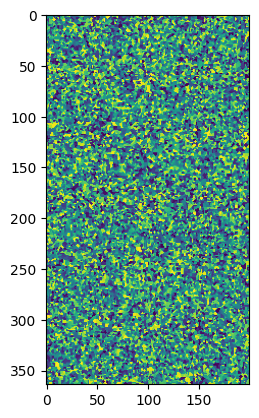

In [46]:
plt.imshow(State)

In [49]:
np.sqrt(np.multiply(*X.shape[1:])/20000) * L

0.003434183032979404

In [50]:
C = np.zeros(State.shape,dtype='float')
C[State>0] = 1

## Run the algorthm

__The algorithm:__

- Wherever $f_s$ is not 1, make State and Concentrations 0

- Find where $f_s$ is 1 in the next step where it isn't 1 in the current step; that's where growth will happen

- Wherever growth will happen and R is positive, grow till completion

- Clip the growth rate to 3 std deviations around the mean

- Keep the growth rate less than 0.01 and fix the time step accordingly

### New solution

In [51]:
meltplace = (TN>1733) | (FN<0.9)

time_sim, Statelist,Clist = runGrowthSim(L,State,time,RN_anal,upperlim = 0.1,every=False,meltplace=meltplace)

100%|██████████| 42/42 [01:35<00:00,  2.28s/it]


### Results

In [52]:
@interact(x = (0,len(Statelist)-1))
def plot(x):
    print(time[x])
    fig,axs = plt.subplots(1)
    # fig.set_figheight(15)
    fig.set_figwidth(15)
    a = axs.imshow((Statelist[x]).T ,origin='lower',vmin=0)
    fig.colorbar(a)
    # b = axs[1].imshow(FS[x+startstep].T,origin='lower')

interactive(children=(IntSlider(value=21, description='x', max=42), Output()), _dom_classes=('widget-interact'…